In [89]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [90]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other ** -1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Exponent must be a scalar"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo_order = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_order.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo_order):
            node._backward()
    
    

In [91]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

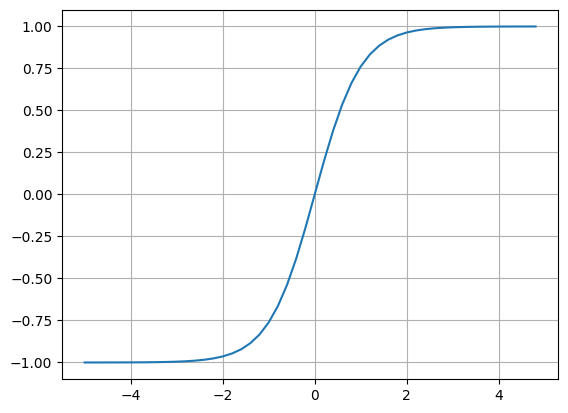

In [92]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [93]:
#Manual calculation of gradients

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# Manually set the gradients
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# n.grad = 0.5
# o.grad = 1.0

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad


In [94]:
#calc gradient each node manually
# o.grad = 1.0

# o._backward()

# n._backward()

# b._backward()

# x1w1x2w2._backward()

# x1w1._backward()

# x2w2._backward()

In [95]:
o.backward()


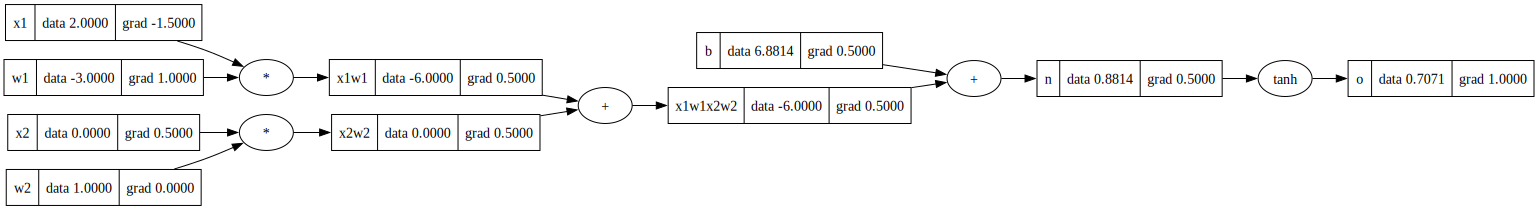

In [96]:
# Print the graph
dot = draw_dot(o)
dot.render('graph')
draw_dot(o)

In [101]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o' ###Tanh definition 
o.backward()

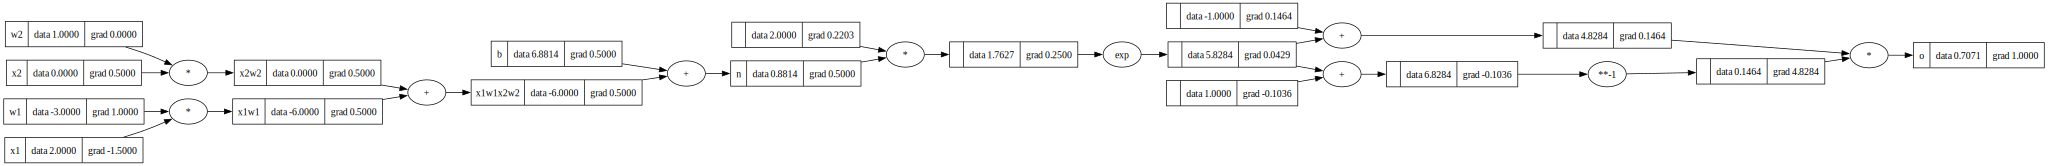

In [102]:
# Print the graph
dot = draw_dot(o)
dot.render('graph')
draw_dot(o)